# Convolutional Autoencoder

Development of convolutional autoencoder using keras/tensorflow backend to encode fashion images from the DeepFashion dataset to create image-based feature vectors


In [2]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import os, pickle

os.chdir("/home/dawnis/Dropbox/Insight/SmartMirror_Demo/")
from src.fashion_tools import DeepFashion, rgb_image_bounding_box

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[]

In [3]:
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Dropout, MaxPool2D, UpSampling2D
from keras.activations import relu

# Model Architecture

This architecture was chosen to reduce the dimensionality of the RGB image to a 512 element feature vector. This architecture resulted in <4000 trainable parameters, which made iterating on the model architecture much faster.

Improvements on this model might include increasing the initial input size to reduce the checkerboard artifact on the output and creating "skip" connections from the encoded input to various decoder layers to increase the efficiency of training. 

In [4]:
input_img = Input(shape=(128,128,3))
encode1 = Conv2D(16, (3, 3), strides=2, padding="same")(input_img)
maxpool1 = MaxPool2D((2,2))(encode1)
batchn1 = BatchNormalization(epsilon=1e-5, momentum=0.9)(maxpool1)
relu1 = LeakyReLU(alpha=0.2)(batchn1)
encode2 = Conv2D(8, (3, 3), strides=2, padding="same")(relu1)
batchn2 = BatchNormalization(epsilon=1e-5, momentum=0.9)(encode2)
relu2 = LeakyReLU(alpha=0.2)(batchn2)
encoded = Conv2D(8, (3, 3),  activation="relu", strides=2, padding="same")(relu2)

decode1 = Conv2DTranspose(8, (3, 3), strides=2, activation="relu", padding="same")(encoded)
d_batchn1 = BatchNormalization(epsilon=1e-5, momentum=0.9)(decode1)
#drop1 = Dropout(0.5)(d_batchn1)
#skip1 = Concatenate()([drop1, encode2])
#d_relu1 = relu(drop1)
decode2 = Conv2DTranspose(8, (3, 3), strides=2, activation="relu", padding="same")(d_batchn1)
d_batchn2 = BatchNormalization(epsilon=1e-5, momentum=0.9)(decode2)
#drop2 = Dropout(0.5)(d_batchn2)
#d_relu2 = relu(drop2)
#skip2 = Concatenate()([drop2, encode1])
upsample1 = UpSampling2D((2,2))(d_batchn2)
decoded = Conv2DTranspose(3, (3, 3), activation="relu", strides=2, padding="same")(upsample1)

auto_encoder = Model(input_img, decoded)
auto_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 8)         1160      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 8)         32        
__________

# Saving the encoder/decoder separately

Saving the two halves of the autoencoder model separately allows for feature generation (using the encoder) and also testing the decoder (below). 

In [5]:
encoder = Model(input_img, encoded)

In [7]:
decode_layer_start = 9

encoded_input = Input(shape=(8, 8, 8))
decode_layer = auto_encoder.layers[decode_layer_start](encoded_input)
for layer in auto_encoder.layers[decode_layer_start+1:]:
    decode_layer = layer(decode_layer)
    
decoder = Model(encoded_input, decode_layer)

# Pre-Training

Here I just grab the data images and chunk them into convenient 2500-image stacks in order to facilitate multiple training epochs. 

In [11]:
#from joblib import Parallel, delayed
import cv2
import pickle

imgnames = os.listdir("/home/dawnis/Data/SmartMirror_Zolonda_Tops/womens_tops_no_model/")

chunksize = 2500
zchunks = []
for m in range(7):
    zchunks.append([imgnames[imgfile_idx+m*chunksize] for imgfile_idx in range(chunksize)])

zchunks.append([imgnames[imgfile_idx] for imgfile_idx in range(chunksize*7, len(imgnames))])

def process_zolonda_chunks(chunk,filename_to_write):
    fullpath_to_data = "/home/dawnis/Data/SmartMirror_Zolonda_Tops/womens_tops_no_model"
    imglist = [rgb_image_bounding_box("/".join([fullpath_to_data,img]), [], autocrop=True) for img in chunk]
    imgresize_list = [cv2.resize(x, (128,128)) for x in imglist]
    pickle.dump(imgresize_list, open(filename_to_write, 'wb'))
    return

In [8]:
zfull = '/home/dawnis/Data/SmartMirror_Zolonda_Tops/womens_tops_no_model'
testimg = rgb_image_bounding_box("/".join([zfull, imgnames[0] ]), [], convert_bgr=False)
testimg_autcrop = rgb_image_bounding_box("/".join([zfull, imgnames[0] ]), [], autocrop=True)

In [9]:
#let's confirm that we split it up right
items_per_chunk = [len(zchunks[x]) for x in range(8)]
np.sum(np.array(items_per_chunk))

19591

In [12]:
savefiles = ["zdata_128x128_chunk{:02d}.pkl".format(x) for x in range(8)]

In [14]:
#with Parallel(n_jobs=-1, verbose=45, backend="threading") as parallel:
    #img_training_data = parallel(delayed(process_training_chunks)(K, topDict) for K in dataChunks)                                  
    #img_training_data = parallel(delayed(process_zolonda_chunks)(K, savefile) for K, savefile in zip(zchunks, savefiles))                                 

for chunk, savefile in zip(zchunks, savefiles):
    print("processing chunk {}".format(savefile))
    process_zolonda_chunks(chunk, savefile)

processing chunk zdata_128x128_chunk00.pkl
processing chunk zdata_128x128_chunk01.pkl
processing chunk zdata_128x128_chunk02.pkl
processing chunk zdata_128x128_chunk03.pkl
processing chunk zdata_128x128_chunk04.pkl
processing chunk zdata_128x128_chunk05.pkl
processing chunk zdata_128x128_chunk06.pkl
processing chunk zdata_128x128_chunk07.pkl


# Model Training

The auto-encoder is compiled with a binary crossentropy loss and adadelta optimizer. This type of loss seemed to work much better than MSE.

In [15]:
auto_encoder.compile(loss="binary_crossentropy", optimizer="adadelta")
for epoch, datafile in enumerate(savefiles):
    xDat = np.array( pickle.load(open(datafile, "rb")) )
    xDat = xDat / 255.
    for trial in range(3):
        np.random.shuffle(xDat)
        x_train = xDat[:2000,:,:,:]
        x_test = xDat[2000:,:,:,:]
        auto_encoder.fit(x_train, x_train, epochs=1, batch_size=50, shuffle=False, validation_data=(x_test, x_test))

Train on 2000 samples, validate on 500 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 4.8706 - val_loss: 3.9218
Train on 2000 samples, validate on 500 samples
Epoch 1/1
2000/2000 [==============================] - 13s 6ms/step - loss: 2.6564 - val_loss: 2.1791
Train on 2000 samples, validate on 500 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.8535 - val_loss: 1.7009
Train on 2000 samples, validate on 500 samples
Epoch 1/1
2000/2000 [==============================] - 13s 6ms/step - loss: 1.5107 - val_loss: 1.3376
Train on 2000 samples, validate on 500 samples
Epoch 1/1
2000/2000 [==============================] - 13s 7ms/step - loss: 1.1968 - val_loss: 1.0160
Train on 2000 samples, validate on 500 samples
Epoch 1/1
2000/2000 [==============================] - 13s 7ms/step - loss: 0.9929 - val_loss: 0.9158
Train on 2000 samples, validate on 500 samples
Epoch 1/1
2000/2000 [==============================] - 13s 

# Testing the encoder/decoder

Below I save the encoder, decoder and auto_encoder for deployment (mainly just the encoder). Then I load some images to visualize how the decoded images look after encoding to get a sense of what features are preserved (see #7)

In [16]:
#It works!
encoder.compile(loss="binary_crossentropy", optimizer="Adam")
decoder.compile(loss="binary_crossentropy", optimizer="Adam") #just to get rid of annoying warning on load
encoder.save("u_encoder_model_current.h5")
encoder.save_weights("u_encoder_model_weights_current.h5")
decoder.save("u_decoder_model_current.h5")
decoder.save_weights("u_decoder_model_weights_current.h5")
auto_encoder.save("u_autoencoder_model.h5")
auto_encoder.save_weights("u_autoencoder_model_weights.h5")

In [12]:
"""
test_input_img = img_training_data[3][67:67+50]
test_input_img = np.array(test_input_img)

decode_img = auto_encoder.predict(test_input_img/255.)
#replace with encoder/decoder pair to help with validation of loaded model
"""

'\ntest_input_img = img_training_data[3][67:67+50]\ntest_input_img = np.array(test_input_img)\n\ndecode_img = auto_encoder.predict(test_input_img/255.)\n#replace with encoder/decoder pair to help with validation of loaded model\n'

In [17]:
from src.fashion_tools import DeepFashion
topDict = DeepFashion("Top")
deepKeys = [key for key in topDict]

zolonda_test_imgs = []
for sv in savefiles:
    imglist = pickle.load(open(sv, "rb"))
    zolonda_test_imgs.append(imglist[:4])

In [18]:
test_imgs = np.concatenate(zolonda_test_imgs)
test_imgs.shape

(32, 128, 128, 3)

In [19]:
import random
dfSample = random.sample(deepKeys,18)

fullpath_to_data = "/home/dawnis/Data/SmartMirror/DeepFashion_Data"
dfSet = [rgb_image_bounding_box("/".join([fullpath_to_data,img]), topDict[img], autocrop=True) for img in dfSample]
dfSet = [cv2.resize(x, (128,128)) for x in dfSet]
test_imgs_input = np.concatenate((test_imgs, np.array(dfSet)), axis=0)

In [21]:
from keras.models import load_model
encoder = load_model("u_encoder_model_current.h5")
encoder.load_weights("u_encoder_model_weights_current.h5")
decoder = load_model("u_decoder_model_current.h5")
decoder.load_weights("u_decoder_model_weights_current.h5")


In [22]:
encoderinput = test_imgs_input/255.

encoded_img = encoder.predict(encoderinput)
decode_img = decoder.predict(encoded_img)

#decode_img = auto_encoder.predict(encoderinput)

In [23]:
decode_reconstruct = np.zeros_like(decode_img, dtype='uint8')
for img in range(decode_img.shape[0]):
    tempimg = decode_img[img,:,:,:]
    tempimg -= np.min(tempimg)
    tempimg /= np.max(tempimg)
    tempimg *= 255
    decode_reconstruct[img,:,:,:] = tempimg.astype('uint8')

# Visualization of encoded/decoded images

The input images (top) are plotted with the encoded/decoded partners (bottom) to get a sense of how well the autoencoder is doing at extracting essenstial information from the fashion images. It seems to be most sensitive to the overall shape and outline of the clothes and has some sense of light/dark but does not seem to capture color well. 

The checkerboard artifacts are due to using maxpool on relative small input size images and would be reduced if larger inputs were used instead. 

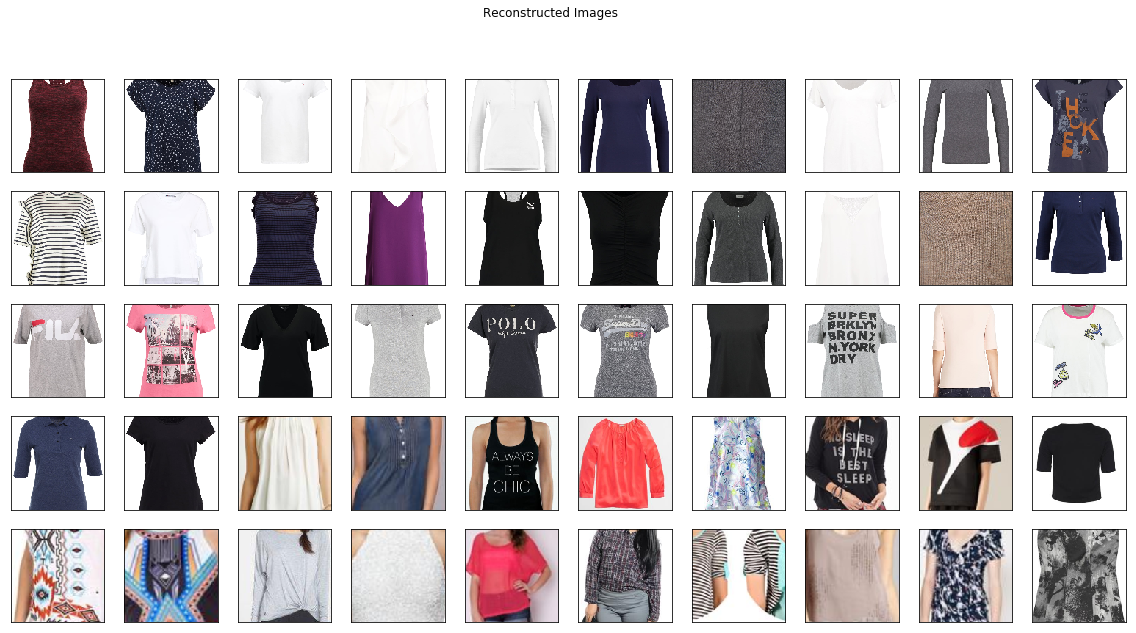

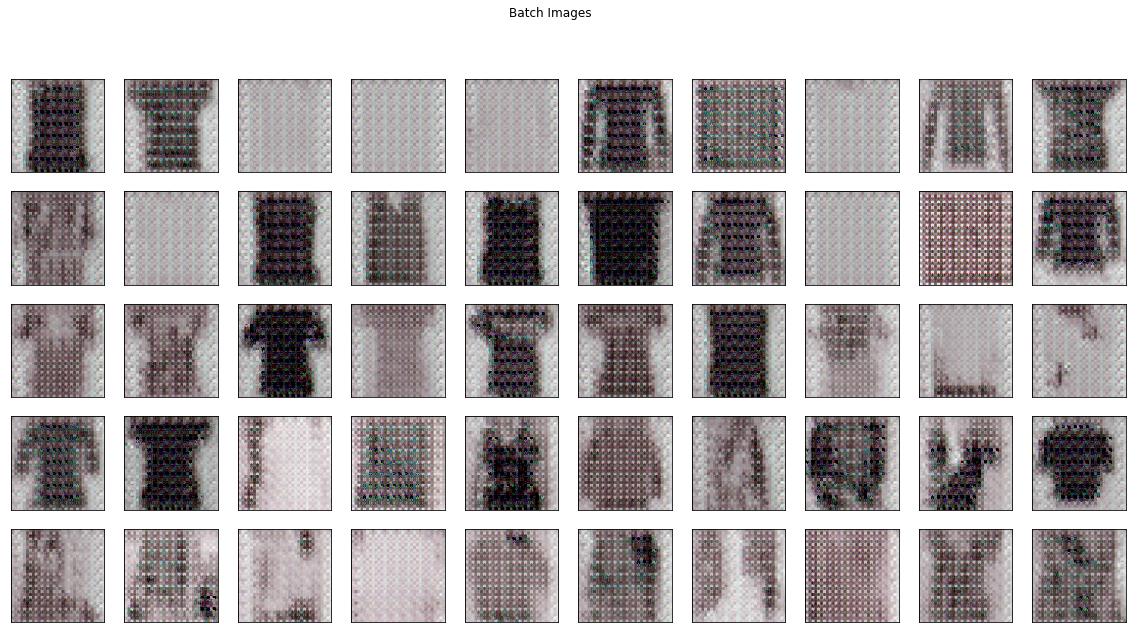

In [24]:
# plot the reconstructed images and their ground truths (inputs)
f1, ax1 = plt.subplots(5, 10)
f1.set_figheight(10)
f1.set_figwidth(20)

f1.suptitle('Reconstructed Images')
i=0
for row in range(5):
    for column in range(10):
        RGB_im = test_imgs_input[i,:,:,:].astype('uint8')
        #RGB_im = np.transpose(RGB_im,axes=(1, 2, 0))
        RGB_im = cv2.cvtColor(RGB_im, cv2.COLOR_BGR2RGB)
        ax1[row][column].imshow(RGB_im)
        ax1[row][column].set_xticks([])
        ax1[row][column].set_yticks([])
        ax1[row][column].imshow(RGB_im)
        i+=1
    
f2, ax2 = plt.subplots(5, 10)
f2.set_figheight(10)
f2.set_figwidth(20)

f2.suptitle('Batch Images')
i=0
for row in range(5):
    for column in range(10):
        RGB_im = decode_reconstruct[i,:,:,:]
        RGB_im = cv2.cvtColor(RGB_im, cv2.COLOR_BGR2RGB)
        ax2[row][column].imshow(RGB_im)
        ax2[row][column].set_xticks([])
        ax2[row][column].set_yticks([])
        ax2[row][column].imshow(RGB_im)
        i+=1